In [1]:
import cobra
import GEMS
import pandas as pd
import numpy as np
import os
import re


import pickle
from etcpy import etc
from etcpy import tempDep
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:
data = GEMS.load_exp_data('../data/ExpGrowth.csv')
path = '../'
params = pd.read_csv(os.path.join(path,'data/BestParamsTopt129.csv'),index_col=0)
df = etc.calculate_thermal_params(params)

dfae_batch = data[25].set_index('Ts').rename_axis(None)
params

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std,topt_source,TmTag
P77467,312.581885,10,262,315.525470,7.588735,NaN,-4934.391324,1000,predicted,Mean
P76077,316.249662,10,309,341.198282,7.588735,NaN,-3031.895628,1000,predicted,Mean
P76078,316.889489,10,95,336.876992,7.588735,NaN,-4970.916037,1000,BullShit,Mean
P76079,315.569489,10,248,351.858297,7.588735,NaN,-2296.738492,1000,predicted,Mean
P76081,317.436480,10,356,330.800735,7.588735,NaN,-3212.147663,1000,BullShit,Mean
...,...,...,...,...,...,...,...,...,...,...
P0AG80,316.761813,10,438,324.738737,4.070000,330.45,-5800.075533,1000,predicted,Exp
P77718,309.573269,10,482,319.125751,4.070000,320.15,-5078.319618,1000,predicted,Exp
P0A6D5,314.182243,10,288,317.369952,7.710000,NaN,-4036.145478,1000,predicted,Mean
standard,313.546929,10,272,325.206318,7.710000,NaN,-4108.399459,1000,BullShit,Mean


In [3]:
def aerobic(params):
    # thermalParams: a dictionary with ids like uniprotid_Topt 
    df = etc.calculate_thermal_params(params)
    #mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    mae = cobra.io.load_matlab_model('../models/ecModel.mat')
    
    medium = cobra.medium.minimal_medium(mae)
    #medium = mae.medium 
    #medium['EX_glc__D_e']=2
    mae.medium = medium
    #mae.reactions.EX_glc__D_e.lower_bound = -50
    #mae.reactions.BIOMASS_Ec_iJO1366_core_53p95M.upper_bound = 50
    print(mae.medium)
    # match = re.compile('usage_prot_*', re.IGNORECASE)
    # for react in mae.reactions:
    #     if match.match(react.id) and react.lower_bound != -1000:
    #         ori_lb = react.lower_bound
    #         react.lower_bound = ori_lb*0.3

    
    
    try: 
        rae, gae, oae, cae, aae = etc.simulate_growth(mae,dfae_batch.index+273.15,df=df,sigma=0.5)
    except: 
        rae = np.zeros(dfae_batch.shape[0])
        model = None
    
    rae = [0 if x is None else x for x in rae]
    rae = [0 if x<1e-3 else x for x in rae]
    rexp = dfae_batch['r'].values
    print(rae)
    print(abs(rae - dfae_batch['r'].values))
    #print('r2_batch:',r2_score(rexp,rae))
    #print('MSE_ae',MSE(rexp,rae))
    return {'growth':np.array(rae), 'glucose':np.array(gae), 'oxygen': np.array(oae), 'carbonDioxide': np.array(cae), 'acetate': np.array(aae)}, r2_score(rexp,rae), MSE(rexp,rae)

In [4]:
rae, score, mse = aerobic(params)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-29


/home/aditi/.local/lib/python3.10/site-packages/cobra/medium/minimal_medium.py:112: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  medium = pd.Series()


{'EX_ca2_e': 0.0005205, 'EX_cl_e': 0.0005205, 'EX_cobalt2_e': 2.5e-06, 'EX_cu2_e': 7.09e-05, 'EX_fe2_e': 0.0016060999999999996, 'EX_glc__D_e': 1.7276264119660734, 'EX_k_e': 0.019519300000000003, 'EX_mg2_e': 0.0008675000000000001, 'EX_mn2_e': 6.91e-05, 'EX_mobd_e': 1.29e-05, 'EX_nh4_e': 1.0800823999999865, 'EX_ni2_e': 3.23e-05, 'EX_o2_e': 2.597483667508012, 'EX_pi_e': 0.09646309999999042, 'EX_so4_e': 0.02522100000000004, 'EX_zn2_e': 3.41e-05}
NGAM is: 3.23


/home/aditi/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Failed to solve the problem
Growth at  10.0 is:  0
NGAM is: 3.23
Growth at  20.0 is:  0.06986992732455527
NGAM is: 4.676981312737154
Growth at  30.0 is:  0.08213377687170996
NGAM is: 5.520448590995495
Growth at  34.0 is:  0.0743163658523657
NGAM is: 5.6976257511114055
Growth at  35.0 is:  0.0725740503919371
NGAM is: 5.863221621030808
Growth at  36.0 is:  0.07090868761431705
NGAM is: 6.018057573240736
Growth at  37.0 is:  0.06934029068020146
NGAM is: 6.2984273062222
Growth at  39.0 is:  0.06647257898323636
NGAM is: 6.544142507117022
Growth at  41.0 is:  0.06391466047611324
NGAM is: 6.759830078566373
Growth at  43.0 is:  0.061616838088416684
NGAM is: 6.949455927668394
Growth at  45.0 is:  0.0595257169289967
[0, 0.06986992732455527, 0.08213377687170996, 0.0743163658523657, 0.0725740503919371, 0.07090868761431705, 0.06934029068020146, 0.06647257898323636, 0.06391466047611324, 0.061616838088416684, 0.0595257169289967]
[0.021096   0.02666993 0.00077378 0.02180363 0.02750595 0.03133131
 0.033

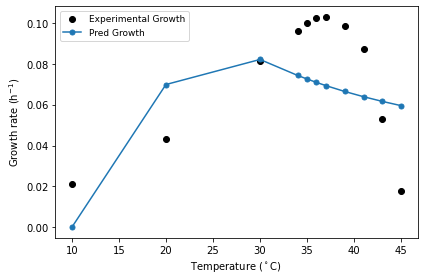

In [5]:
plt.figure()
plt.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
plt.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')
#plt.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose')
#plt.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen')
plt.xlabel('Temperature ($^\circ$C)')
#plt.ylabel('Specific growth rate (h$^{-1}$)')
plt.ylabel('Growth rate (h$^{-1}$)')

plt.legend(fontsize=9,loc='upper left')
plt.tight_layout()
#plt.savefig('../results/plots/initialSimulation.svg')
plt.show()

In [6]:
df = pd.DataFrame(columns=['iter', 'temp', 'growth', 'o2flux', 'gluFlux', 'co2flux', 'acetateFlux', 'R2', 'MSE'])
df['iter'] = [25 for j in range(len(dfae_batch.index))]
df['temp'] = dfae_batch.index
df['growth'] = rae['growth']
df['o2flux'] = rae['oxygen']
df['gluFlux'] = rae['glucose']
df['co2flux'] = rae['carbonDioxide']
df['acetateFlux'] = rae['acetate']
df['R2'] = [score for j in range(len(dfae_batch.index))]
df['MSE'] = [mse for j in range(len(dfae_batch.index))]
df

,iter,temp,growth,o2flux,gluFlux,co2flux,acetateFlux,R2,MSE
0,25,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.28051,0.000718
1,25,20.0,0.069870,2.597484,1.727626,-1.984988,-0.470029,0.28051,0.000718
2,25,30.0,0.082134,2.597484,1.727626,-2.618174,-2.033488,0.28051,0.000718
3,25,34.0,0.074316,2.597484,1.727626,-2.540538,-2.171797,0.28051,0.000718
4,25,35.0,0.072574,2.597484,1.727626,-2.523131,-2.202571,0.28051,0.000718
5,25,36.0,0.070909,2.597484,1.727626,-2.506429,-2.231954,0.28051,0.000718
6,25,37.0,0.069340,2.597484,1.727626,-2.490632,-2.259592,0.28051,0.000718
7,25,39.0,0.066473,2.597484,1.727626,-2.461512,-2.310009,0.28051,0.000718
8,25,41.0,0.063915,2.597484,1.727626,-2.435163,-2.354792,0.28051,0.000718
9,25,43.0,0.061617,2.597484,1.727626,-2.411068,-2.394809,0.28051,0.000718


In [7]:
df.to_csv('../results/mmOnly.csv')